In [1]:
options(pkgType = "binary", repos = "https://cran-archive.r-project.org/")

In [27]:
#install.packages("readr")
#install.packages("hdm")
#install.packages("glmnet")
#install.packages("Matrix")
#install.packages("ggplot2")
#install.packages("xtable")
#install.packages("randomForest")
#install.packages("sandwich")
library(readr)
library(hdm)
library(glmnet)
library(Matrix)
library(ggplot2)
library(xtable)
library(randomForest)
library(sandwich)

Installing package into 'C:/Users/user/Documents/R/win-library/3.6'
(as 'lib' is unspecified)


package 'xtable' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\user\AppData\Local\Temp\RtmpAhL4iN\downloaded_packages


Installing package into 'C:/Users/user/Documents/R/win-library/3.6'
(as 'lib' is unspecified)


package 'randomForest' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\user\AppData\Local\Temp\RtmpAhL4iN\downloaded_packages


Installing package into 'C:/Users/user/Documents/R/win-library/3.6'
(as 'lib' is unspecified)


package 'sandwich' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\user\AppData\Local\Temp\RtmpAhL4iN\downloaded_packages


Warning message:
"package 'xtable' was built under R version 3.6.3"Warning message:
"package 'randomForest' was built under R version 3.6.3"randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:dplyr':

    combine

The following object is masked from 'package:ggplot2':

    margin

Warning message:
"package 'sandwich' was built under R version 3.6.3"

In [3]:
url <- "https://raw.githubusercontent.com/gsbDBI/ExperimentData/master/eSTI/processed_data/processed_esti.csv"
data <- read.csv(url)
head(data)

y,w,gender_female,gender_male,gender_transgender,ethnicgrp_asian,ethnicgrp_black,ethnicgrp_mixed_multiple,ethnicgrp_other,ethnicgrp_white,partners1,postlaunch,msm,age,imd_decile
1,1,0,1,0,0,0,1,0,0,0,1,0,27,5
0,0,0,1,0,0,0,0,0,1,0,0,0,19,6
0,1,0,1,0,0,1,0,0,0,0,1,0,26,4
0,0,1,0,0,0,0,0,0,1,1,0,0,20,2
1,1,1,0,0,1,0,0,0,0,0,1,0,24,3
1,1,0,1,0,0,0,0,0,1,0,1,0,24,2


# Descriptives

In [4]:
filtered_data <- subset(data, gender_transgender == 1)
count_transgender <- nrow(filtered_data)

df_treat <- subset(data, w == 1)
df_control <- subset(data, w == 0)

In [5]:
ntreat <- nrow(df_treat)
ncontrol <- nrow(df_control)

varlist_treat <- list(df_treat$y,df_treat$gender_male,df_treat$ethnicgrp_white,df_treat$partners1,df_treat$age,df_treat$imd_decile)
varlist_control <- list(df_control$y,df_control$gender_male,df_control$ethnicgrp_white,df_control$partners1,df_control$age, df_control$imd_decile)

table <- matrix(0, nrow = 6, ncol = 8)

for (i in 1:length(varlist_control)) {
    # Treated
    table[i, 2] <- ntreat
    table[i, 3] <- mean(varlist_treat[[i]])
    table[i, 4] <- sd(varlist_treat[[i]])

    # Control
    table[i, 5] <- ncontrol
    table[i, 6] <- mean(varlist_control[[i]])
    table[i, 7] <- sd(varlist_control[[i]])

    # Diff
    table[i, 8] <- mean(varlist_treat[[i]]) - mean(varlist_control[[i]])
}

In [7]:
T <- data.frame(Variables = character(6),
                `n(treat)` = table[, 2],
                `Treatmentmean` = table[, 3],
                `sd(treat)` = table[, 4],
                `n(control)` = table[, 5],
                `Controlmean` = table[, 6],
                `sd(control)` = table[, 7],
                Diff = table[, 8],
                stringsAsFactors = FALSE)

T$Variables[1] <- "y (any STI test)"
T$Variables[2] <- "Male (=1 if male)"
T$Variables[3] <- "White (=1 if white)"
T$Variables[4] <- "Partners (=1 if person has one partner)"
T$Variables[5] <- "Age (years)"
T$Variables[6] <- "Multiple derivation index (decile)"

print(T)

                                Variables n.treat. Treatmentmean sd.treat.
1                        y (any STI test)      921     0.4766558 0.4997261
2                       Male (=1 if male)      921     0.4093377 0.4919788
3                     White (=1 if white)      921     0.7535288 0.4311903
4 Partners (=1 if person has one partner)      921     0.3007600 0.4588377
5                             Age (years)      921    23.1585233 3.5387384
6      Multiple derivation index (decile)      921     3.4603692 1.4658443
  n.control. Controlmean sd.control.         Diff
1        818   0.2114914   0.4086159  0.265164366
2        818   0.4180929   0.4935474 -0.008755233
3        818   0.7420538   0.4377719  0.011474983
4        818   0.2921760   0.4550410  0.008584004
5        818  23.0476773   3.5940146  0.110846083
6        818   3.4841076   1.4860812 -0.023738416


# Linear regression analysis

## Regression Y~T

In [11]:
model1 <- lm(y ~ w, data = data)
b1 <- coef(model1)["w"]
se1 <- summary(model1)$coefficients["w", "Std. Error"]
ci1 <- confint(model1)["w", ]

summary(model1)


Call:
lm(formula = y ~ w, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.4767 -0.4767 -0.2115  0.5233  0.7885 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.21149    0.01605   13.17   <2e-16 ***
w            0.26516    0.02206   12.02   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4591 on 1737 degrees of freedom
Multiple R-squared:  0.0768,	Adjusted R-squared:  0.07627 
F-statistic: 144.5 on 1 and 1737 DF,  p-value: < 2.2e-16


Interpretation: Receiving 1 text message with the web link of an e-STI testing (treatment group) increases the probability of taking a STI test by 0.265 porcentage points (pp) in avarage, compared to those who recieved 1 text message with the web link of a bespoke website listing the locations, contact details, and websites of 7 local sexual health clinics (control 
group. This effect is significant at the 99% confidence leve )

## Y ~ T+X

In [12]:
model2 <- lm(y ~ w + gender_male + ethnicgrp_white + partners1 + age + imd_decile, data = data)
b2 <- coef(model2)["w"]
se2 <- summary(model2)$coefficients["w", "Std. Error"]
ci2 <- confint(model2)["w", ]

summary(model2)


Call:
lm(formula = y ~ w + gender_male + ethnicgrp_white + partners1 + 
    age + imd_decile, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.6608 -0.3538 -0.1903  0.4817  1.0071 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -0.113950   0.079372  -1.436  0.15128    
w                0.262343   0.021732  12.072  < 2e-16 ***
gender_male     -0.092513   0.022323  -4.144 3.57e-05 ***
ethnicgrp_white  0.071200   0.025306   2.814  0.00495 ** 
partners1       -0.066229   0.024217  -2.735  0.00630 ** 
age              0.014992   0.003092   4.849 1.35e-06 ***
imd_decile      -0.004274   0.007379  -0.579  0.56255    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4522 on 1732 degrees of freedom
Multiple R-squared:  0.1071,	Adjusted R-squared:  0.104 
F-statistic: 34.63 on 6 and 1732 DF,  p-value: < 2.2e-16


Interpretation: those in the treatment group had their probability of taking a STI test increase by 0.262pp. This effect is significant at the 99% confidence level. 
Control variables are all statistically significant expect for imd_decile (Multiple derivation index (decile))

## Double Lasso Y ~ T+X

In [23]:
if (!require(glmnet)) install.packages("glmnet")
library(glmnet)

X <- as.matrix(data[, c("gender_male", "ethnicgrp_white", "partners1", "age", "imd_decile")])
w <- data$w
y <- data$y

cv_model3a <- cv.glmnet(X, w, alpha = 1)
cv_model3b <- cv.glmnet(X, y, alpha = 1)

model3a <- glmnet(X, w, alpha = 1, lambda = cv_model3a$lambda.min)
model3b <- glmnet(X, y, alpha = 1, lambda = cv_model3b$lambda.min)

resW <- w - predict(model3a, X)
resY <- y - predict(model3b, X)

lassodf <- data.frame(resY = resY, resW = resW)

model3 <- lm(resY ~ resW, data = lassodf)

b3 <- coef(model3)["resW"]
se3 <- summary(model3)$coefficients["resW", "Std. Error"]
ci3 <- confint(model3)["resW", ]

summary(model3)


Call:
lm(formula = resY ~ resW, data = lassodf)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.6658 -0.3539 -0.1900  0.4791  1.0092 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -6.768e-17  1.083e-02    0.00        1    
resW         2.622e-01  2.169e-02   12.09   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4515 on 1737 degrees of freedom
Multiple R-squared:  0.07756,	Adjusted R-squared:  0.07703 
F-statistic: 146.1 on 1 and 1737 DF,  p-value: < 2.2e-16



Interpretation: those in the treatment group had their probability of taking a STI test increase by 0.261pp. This effect is significant at the 99% confidence level. 

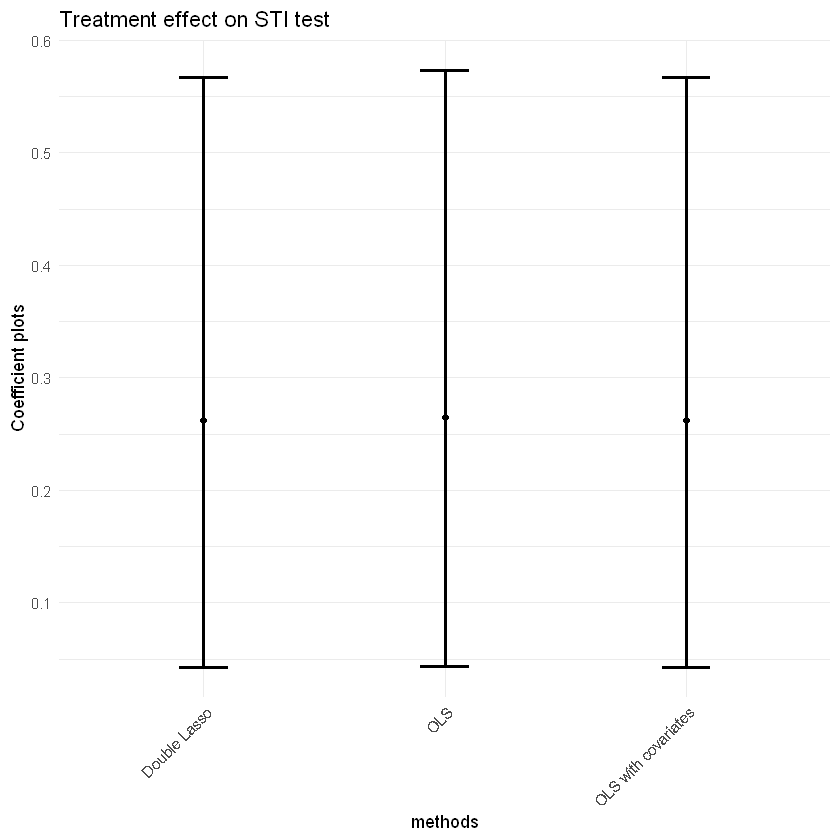

In [25]:
methods <- c("OLS", "OLS with covariates", "Double Lasso")
betas <- c(b1, b2, b3)
ll <- c(ci1[1], ci2[1], ci3[1])
ul <- c(ci1[2], ci2[2], ci3[2])

results_df <- data.frame(methods = methods, betas = betas, ll = ll, ul = ul)

plt <- ggplot(results_df, aes(x = methods, y = betas)) +
    geom_point(color = "black") +
    geom_errorbar(aes(ymin = betas - ll, ymax = betas + ul), width = 0.2, color = "black", size = 1) +
    labs(title = "Treatment effect on STI test", y = "Coefficient plots") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

print(plt)

From all three estimations, linear regressions with covariates yield the lowest standard error (0.0217321) and a point estimate of 0.262343. Point estimates are pretty much similar across methods. 

# Non-Linear Methods DML

In [40]:
# Instalar y cargar librerías necesarias
if (!require("glmnet")) install.packages("glmnet", dependencies=TRUE)
if (!require("randomForest")) install.packages("randomForest", dependencies=TRUE)
if (!require("gbm")) install.packages("gbm", dependencies=TRUE)
if (!require("grf")) install.packages("grf", dependencies=TRUE)
if (!require("dplyr")) install.packages("dplyr", dependencies=TRUE)
if (!require("caret")) install.packages("caret", dependencies=TRUE)
if (!require("sandwich")) install.packages("sandwich", dependencies=TRUE)

library(glmnet)
library(randomForest)
library(gbm)
library(grf)
library(dplyr)
library(caret)
library(sandwich)

Loading required package: gbm
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
"there is no package called 'gbm'"Installing package into 'C:/Users/user/Documents/R/win-library/3.6'
(as 'lib' is unspecified)
also installing the dependencies 'lazyeval', 'rex', 'plyr', 'covr', 'pdp', 'RUnit', 'tinytest', 'vip'



package 'lazyeval' successfully unpacked and MD5 sums checked
package 'rex' successfully unpacked and MD5 sums checked
package 'plyr' successfully unpacked and MD5 sums checked
package 'covr' successfully unpacked and MD5 sums checked
package 'pdp' successfully unpacked and MD5 sums checked
package 'RUnit' successfully unpacked and MD5 sums checked
package 'tinytest' successfully unpacked and MD5 sums checked
package 'vip' successfully unpacked and MD5 sums checked
package 'gbm' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\user\AppData\Local\Temp\RtmpAhL4iN\downloaded_packages


Loading required package: grf
Warning message:
"package 'grf' was built under R version 3.6.3"Loading required package: caret
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
"there is no package called 'caret'"Installing package into 'C:/Users/user/Documents/R/win-library/3.6'
(as 'lib' is unspecified)
also installing the dependencies 'R.methodsS3', 'R.oo', 'R.utils', 'SQUAREM', 'R.cache', 'TH.data', 'profileModel', 'plotrix', 'KernSmooth', 'lava', 'styler', 'classInt', 'labelled', 'gplots', 'libcoin', 'multcomp', 'diffobj', 'gower', 'timeDate', 'brglm', 'gtools', 'qvcalc', 'class', 'plotmo', 'TeachingDemos', 'prodlim', 'combinat', 'questionr', 'ROCR', 'mvtnorm', 'modeltools', 'strucchange', 'coin', 'ISwR', 'corpcor', 'brio', 'desc', 'pkgload', 'praise', 'waldo', 'ModelMetrics', 'reshape2', 'recipes', 'pROC', 'BradleyTerry2', 'e1071', 'earth', 'fastICA', 'gam', 'ipred', 'kernlab', 'klaR', 'ellipse', 'mda', 'mlbench', 'MLmetrics', '

package 'R.methodsS3' successfully unpacked and MD5 sums checked
package 'R.oo' successfully unpacked and MD5 sums checked
package 'R.utils' successfully unpacked and MD5 sums checked
package 'SQUAREM' successfully unpacked and MD5 sums checked
package 'R.cache' successfully unpacked and MD5 sums checked
package 'TH.data' successfully unpacked and MD5 sums checked
package 'profileModel' successfully unpacked and MD5 sums checked
package 'plotrix' successfully unpacked and MD5 sums checked
package 'KernSmooth' successfully unpacked and MD5 sums checked
package 'lava' successfully unpacked and MD5 sums checked
package 'styler' successfully unpacked and MD5 sums checked
package 'classInt' successfully unpacked and MD5 sums checked
package 'labelled' successfully unpacked and MD5 sums checked
package 'gplots' successfully unpacked and MD5 sums checked
package 'libcoin' successfully unpacked and MD5 sums checked
package 'multcomp' successfully unpacked and MD5 sums checked
package 'diffobj'

Warning message:
"package 'gbm' was built under R version 3.6.3"Loaded gbm 2.1.8
Warning message:
"package 'caret' was built under R version 3.6.3"Loading required package: lattice
Warning message:
"package 'lattice' was built under R version 3.6.3"
Attaching package: 'caret'

The following object is masked from 'package:purrr':

    lift

Warning message in file(file, "rt"):
"no fue posible abrir el archivo '/mnt/data/processed_esti.csv': No such file or directory"

ERROR: Error in file(file, "rt"): no se puede abrir la conexión


In [48]:
DML2.for.PLM <- function(x, d, y, dreg, yreg, nfold=2) {
  nobs <- nrow(x) #number of observations
  foldid <- rep.int(1:nfold, times = ceiling(nobs/nfold))[sample.int(nobs)] #define folds indices
  I <- split(1:nobs, foldid)  #split observation indices into folds
  ytil <- dtil <- rep(NA, nobs)
  cat("fold: ")
  for(b in 1:length(I)){
    dfit <- dreg(as.matrix(x[-I[[b]],]), d[-I[[b]]]) #take a fold out
    yfit <- yreg(as.matrix(x[-I[[b]],]), y[-I[[b]]]) # take a fold out
    if (inherits(dfit, "gbm")) {
      dhat <- predict(dfit, data.frame(x[I[[b]],]), n.trees=5000, type="response") #predict the left-out fold for GBM
    } else if (inherits(dfit, "grf")) {
      dhat <- predict(dfit, as.matrix(x[I[[b]],]))$predictions #predict the left-out fold for grf
    } else {
      dhat <- predict(dfit, as.matrix(x[I[[b]],]), type="response") #predict the left-out fold
    }
    if (inherits(yfit, "gbm")) {
      yhat <- predict(yfit, data.frame(x[I[[b]],]), n.trees=5000, type="response") #predict the left-out fold for GBM
    } else if (inherits(yfit, "grf")) {
      yhat <- predict(yfit, as.matrix(x[I[[b]],]))$predictions #predict the left-out fold for grf
    } else {
      yhat <- predict(yfit, as.matrix(x[I[[b]],]), type="response") #predict the left-out fold
    }
    dtil[I[[b]]] <- as.numeric(d[I[[b]]] - dhat) #record residual for the left-out fold
    ytil[I[[b]]] <- as.numeric(y[I[[b]]] - yhat) #record residual for the left-out fold
    cat(b," ")
  }
  rfit <- lm(ytil ~ dtil)    #estimate the main parameter by regressing one residual on the other
  coef.est <- coef(rfit)[2]  #extract coefficient
  se <- sqrt(vcovHC(rfit)[2,2]) #record robust standard error
  cat(sprintf("\ncoef (se) = %g (%g)\n", coef.est , se))  #printing output
  return(list(coef.est = coef.est , se = se, dtil = dtil, ytil = ytil)) #save output and residuals
}

In [50]:
# Lasso
lasso_reg <- function(x, y) {
  cv.glmnet(as.matrix(x), y, alpha=1)
}

# Regression Tree
tree_reg <- function(x, y) {
  randomForest(x, y)
}

# Boosting Trees
boosting_reg <- function(x, y) {
  gbm(y ~ ., data = data.frame(x, y), distribution = "gaussian", n.trees = 5000, interaction.depth = 4, shrinkage = 0.01, cv.folds = 5)
}

# Regression Forest
forest_reg <- function(x, y) {
  regression_forest(as.matrix(x), y)
}

y <- data$y
T <- data$postlaunch
X <- data %>% select(gender_female, gender_male, gender_transgender, age, imd_decile)

# DML with Lasso
result_lasso <- DML2.for.PLM(X, T, y, lasso_reg, lasso_reg)

# DML with Regression Tree
result_tree <- DML2.for.PLM(X, T, y, tree_reg, tree_reg)

# DML with Boosting Trees
result_boosting <- DML2.for.PLM(X, T, y, boosting_reg, boosting_reg)

# DML with Regression Forest
result_forest <- DML2.for.PLM(X, T, y, forest_reg, forest_reg)

fold: 1  2  
coef (se) = 0.106463 (0.0233236)
fold: 

Warning message in randomForest.default(x, y):
"The response has five or fewer unique values.  Are you sure you want to do regression?"Warning message in randomForest.default(x, y):
"The response has five or fewer unique values.  Are you sure you want to do regression?"

1  

Warning message in randomForest.default(x, y):
"The response has five or fewer unique values.  Are you sure you want to do regression?"Warning message in randomForest.default(x, y):
"The response has five or fewer unique values.  Are you sure you want to do regression?"

2  
coef (se) = 0.101367 (0.023279)
fold: 1  2  
coef (se) = 0.103917 (0.0234215)
fold: 1  2  
coef (se) = 0.0929612 (0.0233991)


In [51]:
results <- data.frame(
  Method = c("Lasso", "Regression Tree", "Boosting Trees", "Regression Forest"),
  Coefficient = c(result_lasso$coef.est, result_tree$coef.est, result_boosting$coef.est, result_forest$coef.est),
  SE = c(result_lasso$se, result_tree$se, result_boosting$se, result_forest$se)
)

print(results)

             Method Coefficient         SE
1             Lasso  0.10646307 0.02332358
2   Regression Tree  0.10136749 0.02327899
3    Boosting Trees  0.10391695 0.02342146
4 Regression Forest  0.09296122 0.02339907


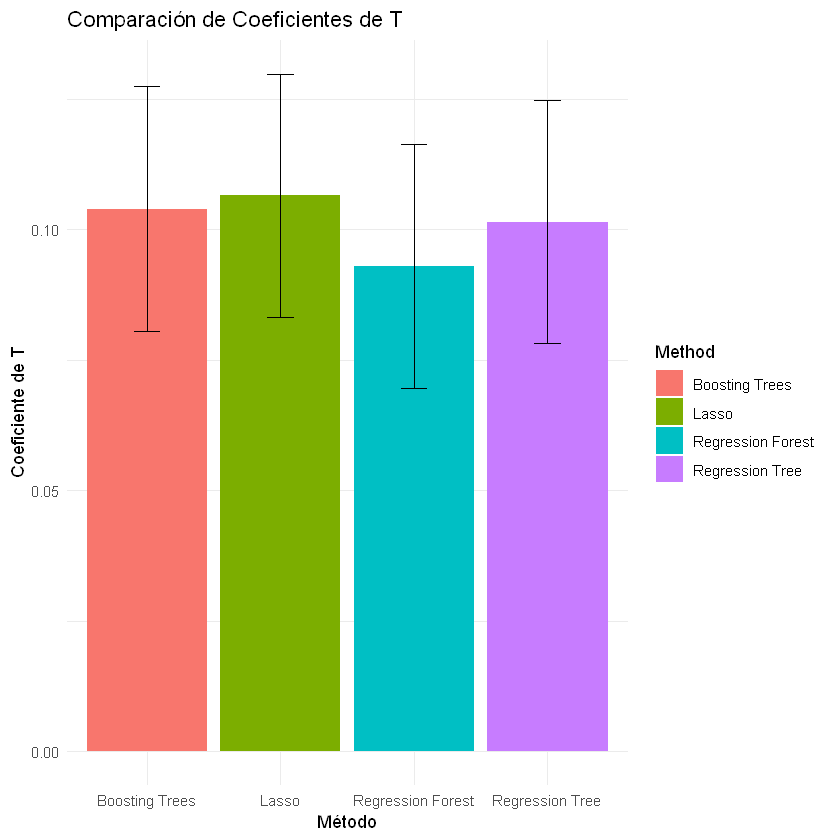

In [52]:
ggplot(results, aes(x = Method, y = Coefficient, fill = Method)) +
  geom_bar(stat = "identity", position = position_dodge()) +
  geom_errorbar(aes(ymin = Coefficient - SE, ymax = Coefficient + SE), width = 0.2, position = position_dodge(0.9)) +
  theme_minimal() +
  labs(title = "Comparación de Coeficientes de T", x = "Método", y = "Coeficiente de T")